# Simuler l'évolution de l'épaisseur d'un glacier en fonction de l'augmentation moyenne des températures

In [1]:
from oggm import cfg
from oggm import tasks, utils, workflow, graphics, DEFAULT_BASE_URL
import xarray as xr
import matplotlib.pyplot as plt
from oggm.sandbox import distribute_2d
from matplotlib import animation
from IPython.display import HTML, display

In [2]:
def sim_thick_by_temp_anim(animation_name = "animation.html", glacier_name = 'RGI60-15.03473', ys=2020, ye=2100, temperature_bias=1.5):
    # Initialize OGGM and set up the default run parameters
    cfg.initialize(logging_level='WARNING')

    # Local working directory (where OGGM will write its output)
    # WORKING_DIR = utils.gettempdir('OGGM_distr4')
    cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)

    rgi_ids = [glacier_name]  # This is Aletsch
    gdir = workflow.init_glacier_directories(rgi_ids, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=4, prepro_border=80)[0]

    # Do a random run with a bit of warming
    tasks.run_random_climate(gdir, 
                         ys=ys, ye=ye,  # Although the simulation is idealised, lets use real dates for the animation
                         y0=2009, halfsize=10,  # Randome climate of 1999-2019
                         seed=1,  # Random number generator seed 
                         temperature_bias=temperature_bias,  # additional warming - change for other scenarios
                         store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                         init_model_filesuffix='_spinup_historical',  # start from the spinup run
                         output_filesuffix='_random_s1',  # optional - here I just want to make things explicit as to which run we are using afterwards
                        );

    # This is to add a new topography to the file (smoothed differently)
    distribute_2d.add_smoothed_glacier_topo(gdir)
    # This is to get the bed map at the start of the simulation
    tasks.distribute_thickness_per_altitude(gdir)
    # This is to prepare the glacier directory for the interpolation (needs to be done only once)
    distribute_2d.assign_points_to_band(gdir)

    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        ds = ds.load()


    ds = distribute_2d.distribute_thickness_from_simulation(gdir, input_filesuffix='_random_s1')

    # Animation
    fig, ax = plt.subplots();

    thk = ds['distributed_thickness'];

    # Plot the initial frame. 
    cax = thk.isel(time=0).plot(ax=ax,
        add_colorbar=True,
        cmap='viridis',
        vmin=0, vmax=350,
        cbar_kwargs={
            'extend':'neither'
        }
    )
    ax.axis('equal');

    def animate(frame):
        
        ax.set_title(f'Year {int(thk.time[frame])}')
        cax.set_array(thk.values[frame, :].flatten())

    ani_glacier = animation.FuncAnimation(fig, animate, frames=len(thk.time), interval=100);

    # Générer le code HTML de l'animation
    animation_html = ani_glacier.to_jshtml();

    # Écrire le code HTML dans un fichier
    with open(animation_name, "w") as html_file:
        html_file.write(animation_html);

2024-04-29 16:31:32: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-04-29 16:31:32: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-04-29 16:31:32: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-04-29 16:31:32: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-04-29 16:31:32: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


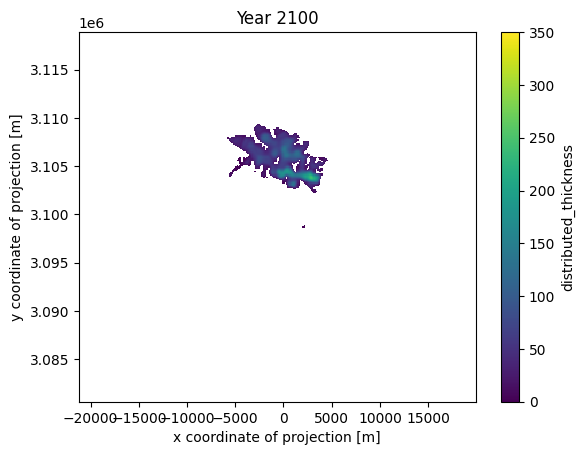

In [4]:
sim_thick_by_temp_anim("evolution_2_5.html", 'RGI60-15.03473', 2020, 2100, 2.5);